In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Purpose of the Test
The purpose of this test is to compare the LSTM and ARIMA models' performances and accuracy on predicting data. <br>
The data used for this purpose is an hourly data of solar radiation for the city centre of Compiégne which contains hourly data on photovoltaic energy, <br>
global horizontal irradiance, 2 meter temperature, etc.


In [3]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("Compiegne_Solar_2021.csv", skiprows=10, skipfooter=10, engine='python')
df_2021 = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne_Solar_2022.csv", skiprows=10, skipfooter=10, engine='python')
df_2022 = pd.DataFrame(dataset)

dataset = pd.read_csv("Compiegne_Solar_2023.csv", skiprows=10, skipfooter=10, engine='python')
df_2023 = pd.DataFrame(dataset)

print(df_2021.head())
print(df_2022.head())
print(df_2023.head())

            time    P  G(i)  H_sun   T2m  WS10m  Int
0  20210101:0010  0.0   0.0    0.0 -0.21   1.59  0.0
1  20210101:0110  0.0   0.0    0.0 -0.44   1.59  0.0
2  20210101:0210  0.0   0.0    0.0 -0.48   1.38  0.0
3  20210101:0310  0.0   0.0    0.0 -0.47   1.24  0.0
4  20210101:0410  0.0   0.0    0.0 -0.50   1.24  0.0
            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1  20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2  20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3  20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4  20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0
            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20230101:0010  0.0   0.0    0.0  14.72   7.52  0.0
1  20230101:0110  0.0   0.0    0.0  14.59   7.17  0.0
2  20230101:0210  0.0   0.0    0.0  14.47   7.03  0.0
3  20230101:0310  0.0   0.0    0.0  14.50   6.69  0.0
4  20230101:0410  0.0   0.0    0.0  14.21   6.07  0.0


In [4]:
print(df_2021.tail())
print(df_2022.tail())
print(df_2022.tail())

               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20211231:1910  0.0   0.0    0.0  10.89   3.17  0.0
8756  20211231:2010  0.0   0.0    0.0  10.66   3.93  0.0
8757  20211231:2110  0.0   0.0    0.0  10.60   3.93  0.0
8758  20211231:2210  0.0   0.0    0.0  10.57   3.10  0.0
8759  20211231:2310  0.0   0.0    0.0  10.63   2.62  0.0
               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20221231:1910  0.0   0.0    0.0  14.96   7.66  0.0
8756  20221231:2010  0.0   0.0    0.0  14.90   7.52  0.0
8757  20221231:2110  0.0   0.0    0.0  14.84   7.45  0.0
8758  20221231:2210  0.0   0.0    0.0  14.84   7.66  0.0
8759  20221231:2310  0.0   0.0    0.0  14.71   7.86  0.0
               time    P  G(i)  H_sun    T2m  WS10m  Int
8755  20221231:1910  0.0   0.0    0.0  14.96   7.66  0.0
8756  20221231:2010  0.0   0.0    0.0  14.90   7.52  0.0
8757  20221231:2110  0.0   0.0    0.0  14.84   7.45  0.0
8758  20221231:2210  0.0   0.0    0.0  14.84   7.66  0.0
8759  20221231:2310  0.0   0.0 

# Explanations of the Variables
<b>P:</b> PV system power (W) <br>
<b>G(i):</b> Global irradiance on the inclined plane (plane of the array) (W/m2) <br>
<b>H_sun:</b> Sun height (degree) <br>
<b>T2m:</b> 2-m air temperature (degree Celsius) <br>
<b>WS10m:</b> 10-m total wind speed (m/s) <br>
<b>Int:</b> 1 means solar radiation values are reconstructed

The time will mostly be irrelevant for our studies since the models can understand the datasets as sequential, but modifying the time data <br>
and changing it to a Datetime object is nevertheless good practice.

In [5]:
df_2021['time'] = pd.to_datetime(df_2021['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2021 = df_2021.set_index(['time'])

df_2022['time'] = pd.to_datetime(df_2022['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2022 = df_2022.set_index(['time'])

df_2023['time'] = pd.to_datetime(df_2023['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_2023 = df_2023.set_index(['time'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\2361934584.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_2021['time'] = pd.to_datetime(df_2021['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\2361934584.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_2022['time'] = pd.to_datetime(df_2022['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\2361934584.py:7: UserWarning: The argument 

In [6]:
df_2021

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2021-01-01 00:10:00,0.0,0.0,0.0,-0.21,1.59,0.0
2021-01-01 01:10:00,0.0,0.0,0.0,-0.44,1.59,0.0
2021-01-01 02:10:00,0.0,0.0,0.0,-0.48,1.38,0.0
2021-01-01 03:10:00,0.0,0.0,0.0,-0.47,1.24,0.0
2021-01-01 04:10:00,0.0,0.0,0.0,-0.50,1.24,0.0
...,...,...,...,...,...,...
2021-12-31 19:10:00,0.0,0.0,0.0,10.89,3.17,0.0
2021-12-31 20:10:00,0.0,0.0,0.0,10.66,3.93,0.0
2021-12-31 21:10:00,0.0,0.0,0.0,10.60,3.93,0.0


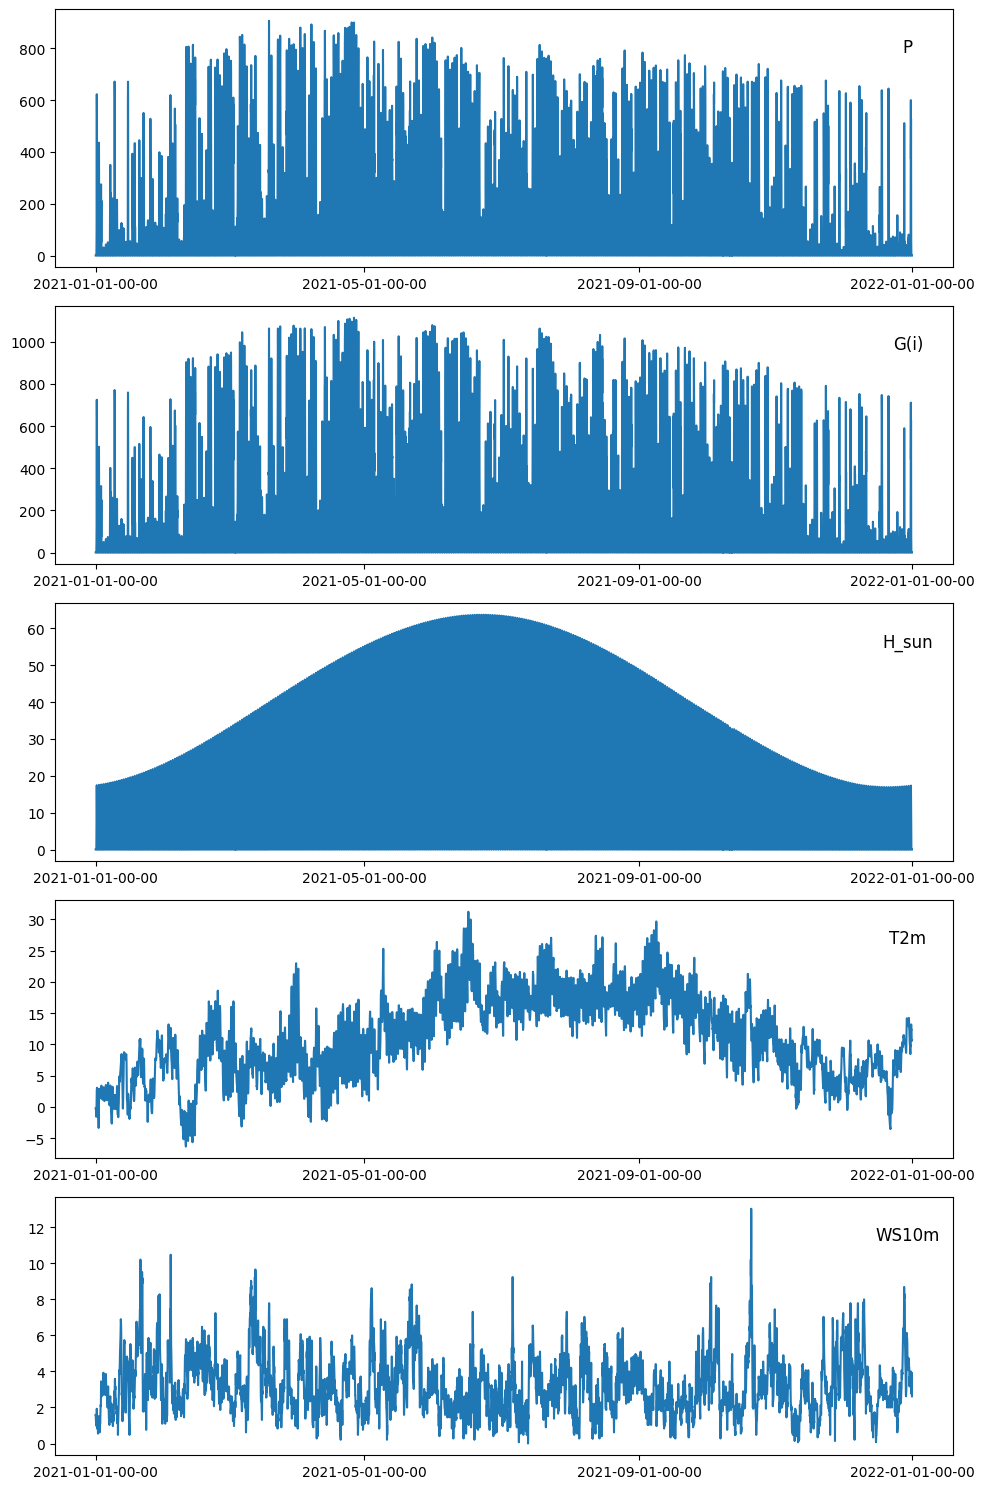

In [7]:
# Creating separate subplots for each series
values = df_2021.values
dates = df_2021.index  # Get the datetime index

# Specify columns to plot
groups = [0, 1, 2, 3, 4]  # The 'Int' column always has the value 0, so it is negatable
i = 1

plt.figure(figsize=(10, 15))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates, values[:, group])  # Use datetime index on x-axis
    plt.title(df_2021.columns[group], y=0.8, x=0.95)

    # Set major x-axis locator to show only 4 dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=5))  # Force 4 labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'

    i += 1

plt.tight_layout()
plt.show()

# Training the LSTM Model (Temperature Prediction)
The LSTM model will be trained on data from 2021 and 2022, and tested on data from 2023.

In [8]:
frames_to_concat = [df_2021, df_2022]

df_2021_2022 = pd.concat(frames_to_concat)

In [9]:
df_2021_2022

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2021-01-01 00:10:00,0.0,0.0,0.0,-0.21,1.59,0.0
2021-01-01 01:10:00,0.0,0.0,0.0,-0.44,1.59,0.0
2021-01-01 02:10:00,0.0,0.0,0.0,-0.48,1.38,0.0
2021-01-01 03:10:00,0.0,0.0,0.0,-0.47,1.24,0.0
2021-01-01 04:10:00,0.0,0.0,0.0,-0.50,1.24,0.0
...,...,...,...,...,...,...
2022-12-31 19:10:00,0.0,0.0,0.0,14.96,7.66,0.0
2022-12-31 20:10:00,0.0,0.0,0.0,14.90,7.52,0.0
2022-12-31 21:10:00,0.0,0.0,0.0,14.84,7.45,0.0


In [10]:
df_2021_2022_Temp = df_2021_2022.iloc[:, [3]]

print(df_2021_2022_Temp.head())

df_2023_Temp = df_2023.iloc[:, [3]]

print(df_2023_Temp.head())

                      T2m
time                     
2021-01-01 00:10:00 -0.21
2021-01-01 01:10:00 -0.44
2021-01-01 02:10:00 -0.48
2021-01-01 03:10:00 -0.47
2021-01-01 04:10:00 -0.50
                       T2m
time                      
2023-01-01 00:10:00  14.72
2023-01-01 01:10:00  14.59
2023-01-01 02:10:00  14.47
2023-01-01 03:10:00  14.50
2023-01-01 04:10:00  14.21


In [11]:
# Preparing dataset for LSTM training

df_lstm_training = df_2021_2022_Temp.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = df_2023_Temp.values
df_lstm_testing = df_lstm_testing.astype('float32')

In [12]:
# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

In [13]:
# Convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# Reshape into X=t and Y=t+1

look_back = 24 # Predicting the next value based on how many previous values
trainX, trainY = create_dataset(df_lstm_training, look_back)
testX, testY = create_dataset(df_lstm_testing, look_back)

In [15]:
# Reshape input to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
np.shape(trainX)

In [ ]:
# Create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=6, verbose=2)

In [ ]:
# Make predictions

trainPredict_LSTM = model.predict(trainX)
testPredict_LSTM = model.predict(testX)

# Invert predictions

trainPredict_LSTM = scaler.inverse_transform(trainPredict_LSTM)
trainY = scaler.inverse_transform([trainY])
testPredict_LSTM = scaler.inverse_transform(testPredict_LSTM)
testY = scaler.inverse_transform([testY])

# Calculate overall root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict_LSTM[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict_LSTM[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Compute per-prediction RMSE (not aggregated)
trainRMSE_each = np.sqrt((trainPredict_LSTM[:,0] - trainY[0]) ** 2)
testRMSE_each = np.sqrt((testPredict_LSTM[:,0] - testY[0]) ** 2)

# Round RMSE values to 3 decimal places
trainRMSE_each = np.round(trainRMSE_each, 3)
testRMSE_each = np.round(testRMSE_each, 3)

# Print first 10 RMSE values as an example
print("First 10 Train RMSE values:", trainRMSE_each[:10])
print("First 10 Test RMSE values:", testRMSE_each[:10])

In [ ]:
# Shift train predictions for plotting

trainPredictPlot = np.empty_like(df_lstm_training)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_LSTM)+look_back, :] = trainPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_training), 'g', label='Original Dataset')
plt.plot(trainPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne Between the Years 2021 - 2022')
plt.show()

In [ ]:
# Shift train predictions for plotting

testPredictPlot = np.empty_like(df_lstm_testing)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(testPredict_LSTM)+look_back, :] = testPredict_LSTM

# Plot baseline and predictions

plt.plot(scaler.inverse_transform(df_lstm_testing), 'g', label='Original Dataset')
plt.plot(testPredictPlot, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

In [ ]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(scaler.inverse_transform(df_lstm_testing)[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(testPredictPlot[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

In [ ]:
# Creating a graph for the RMSE values

plt.plot(trainRMSE_each, 'purple', label='RMSE Values of Training')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Training Data Values')
plt.show()

In [ ]:
# Finding the maximum and minimum RMSE values

maxRMSE_train, minRMSE_train = max(trainRMSE_each), min(trainRMSE_each)

print("Maximum RMSE for training data: ", maxRMSE_train)
print("Minimum RMSE for training data: ", minRMSE_train)

In [ ]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(trainRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = trainRMSE_each[max_index:max_index + window_size]
min_interval = trainRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

In [ ]:
# Creating a graph for the RMSE values

plt.plot(testRMSE_each, 'purple', label='RMSE Values of Testing')
plt.legend(fontsize=7)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values Between the Predicted Data and the Actual Testing Data Values')
plt.show()

In [ ]:
# Finding the maximum and minimum RMSE values

maxRMSE_test, minRMSE_test = max(testRMSE_each), min(testRMSE_each)

print("Maximum RMSE for testing data: ", maxRMSE_test)
print("Minimum RMSE for testing data: ", minRMSE_test)

In [ ]:
# Finding the worst guessed and best guessed weeks

window_size = 168  # Length of interval
rolling_avg = np.convolve(testRMSE_each, np.ones(window_size)/window_size, mode='valid')

# Find the indices of the highest and lowest 168-element average
max_index = np.argmax(rolling_avg)  # Index where the highest average starts
min_index = np.argmin(rolling_avg)  # Index where the lowest average starts

# Extract the corresponding intervals
max_interval = testRMSE_each[max_index:max_index + window_size]
min_interval = testRMSE_each[min_index:min_index + window_size]

print(f"Highest 168-element average starts at index {max_index}, value: {np.max(rolling_avg):.3f}")
print(f"Lowest 168-element average starts at index {min_index}, value: {np.min(rolling_avg):.3f}")

In [29]:
# Save to a file
np.save("testRMSE_each.npy", testRMSE_each)
np.save("testPredict_LSTM.npy", testPredict_LSTM)

# Predicting Temperature With Multiple Features

In [11]:
df_2021_2022_copy = df_2021_2022
print(df_2021_2022_copy.head())

df_2023_copy = df_2023
print(df_2023_copy.head())

                       P  G(i)  H_sun   T2m  WS10m  Int
time                                                   
2021-01-01 00:10:00  0.0   0.0    0.0 -0.21   1.59  0.0
2021-01-01 01:10:00  0.0   0.0    0.0 -0.44   1.59  0.0
2021-01-01 02:10:00  0.0   0.0    0.0 -0.48   1.38  0.0
2021-01-01 03:10:00  0.0   0.0    0.0 -0.47   1.24  0.0
2021-01-01 04:10:00  0.0   0.0    0.0 -0.50   1.24  0.0
                       P  G(i)  H_sun    T2m  WS10m  Int
time                                                    
2023-01-01 00:10:00  0.0   0.0    0.0  14.72   7.52  0.0
2023-01-01 01:10:00  0.0   0.0    0.0  14.59   7.17  0.0
2023-01-01 02:10:00  0.0   0.0    0.0  14.47   7.03  0.0
2023-01-01 03:10:00  0.0   0.0    0.0  14.50   6.69  0.0
2023-01-01 04:10:00  0.0   0.0    0.0  14.21   6.07  0.0


In [12]:
value = 1.0
 
result = df_2021_2022_copy[df_2021_2022_copy['Int'] == value]
 
print(result, '\n')

result = df_2023_copy[df_2023_copy['Int'] == value]
 
print(result)

Empty DataFrame
Columns: [P, G(i), H_sun, T2m, WS10m, Int]
Index: [] 

Empty DataFrame
Columns: [P, G(i), H_sun, T2m, WS10m, Int]
Index: []


In [13]:
# We can drop the int column
# Int is dropped because it is 0 for every row

df_2021_2022_dropped = df_2021_2022_copy.drop(['Int'], axis=1)

print(df_2021_2022_dropped.head())

df_2023_dropped = df_2023_copy.drop(['Int'], axis=1)

print(df_2023_dropped.head())

                       P  G(i)  H_sun   T2m  WS10m
time                                              
2021-01-01 00:10:00  0.0   0.0    0.0 -0.21   1.59
2021-01-01 01:10:00  0.0   0.0    0.0 -0.44   1.59
2021-01-01 02:10:00  0.0   0.0    0.0 -0.48   1.38
2021-01-01 03:10:00  0.0   0.0    0.0 -0.47   1.24
2021-01-01 04:10:00  0.0   0.0    0.0 -0.50   1.24
                       P  G(i)  H_sun    T2m  WS10m
time                                               
2023-01-01 00:10:00  0.0   0.0    0.0  14.72   7.52
2023-01-01 01:10:00  0.0   0.0    0.0  14.59   7.17
2023-01-01 02:10:00  0.0   0.0    0.0  14.47   7.03
2023-01-01 03:10:00  0.0   0.0    0.0  14.50   6.69
2023-01-01 04:10:00  0.0   0.0    0.0  14.21   6.07


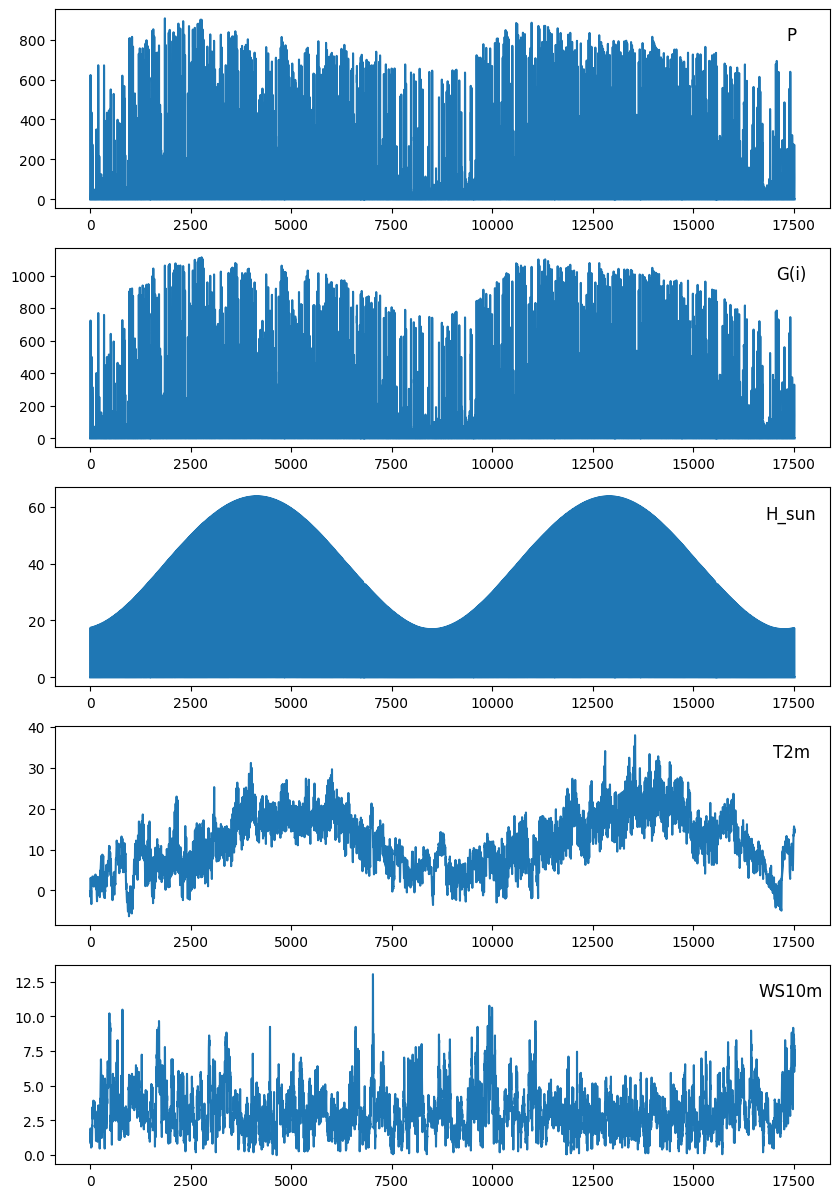

In [14]:
# Creating separate subplots for each series
values = df_2021_2022_dropped.values

# Specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1

# Plot each column
plt.figure(figsize=(10, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_2021_2022_dropped.columns[group], y=0.8, x=0.95)
	i += 1
plt.show()

In [ ]:
# Splitting the dataset into training and testing sets
df_for_training=df_2021_2022_dropped
df_for_testing=df_2023_dropped
print(df_for_training.shape)
print(df_for_testing.shape)

In [ ]:
# Normalizing the values
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

In [18]:
# Creating the training and testing datasets

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

look_back = 24

trainX,trainY=createXY(df_for_training_scaled,look_back)
testX,testY=createXY(df_for_testing_scaled,look_back)

In [ ]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

In [ ]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

In [ ]:
# Building the model

def build_model(optimizer):

    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model('adam'),verbose=1)

parameters = {'batch_size' : [24], 'epochs' : [300], 'optimizer' : ['adam']}

grid_search  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv=2) # Hyperparameter tuning to find the best parameters

In [ ]:
grid_search = grid_search.fit(trainX,trainY) # Finding the best estimator to train the model

In [ ]:
grid_search.best_params_

In [24]:
my_model = grid_search.best_estimator_

In [ ]:
print(my_model)

In [ ]:
prediction = my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-", prediction.shape)

In [27]:
# scaler.inverse_transform(prediction)

In [28]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [ ]:
prediction_copies_array.shape

In [30]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [31]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [ ]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

In [ ]:
plt.plot(original, color = 'red', label = 'Real data')
plt.plot(pred, color = 'blue', label = 'Predicted Data')
plt.title('Compiegne 2023 Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Original')
plt.legend()
plt.show()

In [35]:
# Save to a file
np.save("testMultipleFeature_LSTM.npy", pred)
np.save("originalMultipleFeature_LSTM.npy", original)

# Predicting Multiple Time Steps Ahead

In [15]:
print(df_2021_2022_Temp.head())
print(df_2023_Temp.head())

                      T2m
time                     
2021-01-01 00:10:00 -0.21
2021-01-01 01:10:00 -0.44
2021-01-01 02:10:00 -0.48
2021-01-01 03:10:00 -0.47
2021-01-01 04:10:00 -0.50
                       T2m
time                      
2023-01-01 00:10:00  14.72
2023-01-01 01:10:00  14.59
2023-01-01 02:10:00  14.47
2023-01-01 03:10:00  14.50
2023-01-01 04:10:00  14.21


In [16]:
# resample data to daily
hourly_groups = df_2021_2022_Temp.resample('H')
hourly_data_training = hourly_groups.sum()

# summarize
print(hourly_data_training.shape)
print(hourly_data_training.head())

# resample data to daily
hourly_groups_testing = df_2023_Temp.resample('H')
hourly_data_testing = hourly_groups_testing.sum()

# summarize
print(hourly_data_testing.shape)
print(hourly_data_testing.head())

(17520, 1)
                      T2m
time                     
2021-01-01 00:00:00 -0.21
2021-01-01 01:00:00 -0.44
2021-01-01 02:00:00 -0.48
2021-01-01 03:00:00 -0.47
2021-01-01 04:00:00 -0.50
(8760, 1)
                       T2m
time                      
2023-01-01 00:00:00  14.72
2023-01-01 01:00:00  14.59
2023-01-01 02:00:00  14.47
2023-01-01 03:00:00  14.50
2023-01-01 04:00:00  14.21


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\1869168067.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = df_2021_2022_Temp.resample('H')
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\1869168067.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups_testing = df_2023_Temp.resample('H')


In [17]:
# save
hourly_data_training.to_csv('Hourly_Temp_System_Power_Data_Training.csv')
hourly_data_testing.to_csv('Hourly_Temp_System_Power_Data_Testing.csv')

In [18]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [19]:
def reframe_datasets(training, testing):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/24))
	test = array(np.split(testing, len(testing)/24))
	
	return train, test

In [20]:
# load the new file
dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
train, test = reframe_datasets(dataset_training.values, dataset_testing.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(730, 24, 1)
-0.21 14.71
(365, 24, 1)
14.72 7.82


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\737085104.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\737085104.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])


In [21]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [22]:
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

In [23]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [24]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 300, 24
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(400, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [25]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next day
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [26]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler):

	# history is a list of daily data
	history = [x for x in train]

	# walk-forward validation over each day
	predictions = list()

	for i in range(len(test)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history.append(test[i, :])

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, 1)
	predictions_reshaped = scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, 1)

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)		
	
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, score, scores

In [43]:
# load the new file
dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
train, test = reframe_datasets(dataset_training.values, dataset_testing.values)

# Build a model
n_input = 24
model = build_model(train, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_13876\2533672674.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_13876\2533672674.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
d:\Users\ugurhan

Epoch 1/50
729/729 - 26s - 36ms/step - loss: 12.0908
Epoch 2/50
729/729 - 24s - 33ms/step - loss: 5.1835
Epoch 3/50
729/729 - 24s - 33ms/step - loss: 4.8216
Epoch 4/50
729/729 - 24s - 33ms/step - loss: 4.6843
Epoch 5/50
729/729 - 24s - 32ms/step - loss: 4.6229
Epoch 6/50
729/729 - 24s - 33ms/step - loss: 4.5499
Epoch 7/50
729/729 - 24s - 33ms/step - loss: 4.4892
Epoch 8/50
729/729 - 24s - 33ms/step - loss: 4.4280
Epoch 9/50
729/729 - 24s - 33ms/step - loss: 4.3634
Epoch 10/50
729/729 - 24s - 33ms/step - loss: 4.3061
Epoch 11/50
729/729 - 24s - 33ms/step - loss: 4.2551
Epoch 12/50
729/729 - 24s - 33ms/step - loss: 4.1837
Epoch 13/50
729/729 - 24s - 33ms/step - loss: 4.1150
Epoch 14/50
729/729 - 24s - 33ms/step - loss: 4.0407
Epoch 15/50
729/729 - 24s - 33ms/step - loss: 3.9575
Epoch 16/50
729/729 - 24s - 33ms/step - loss: 3.9011
Epoch 17/50
729/729 - 24s - 33ms/step - loss: 3.8566
Epoch 18/50
729/729 - 24s - 33ms/step - loss: 3.7763
Epoch 19/50
729/729 - 24s - 33ms/step - loss: 3.6819
E

[[14.784065  14.650038  14.509173  ... 14.2457485 14.357992  14.492441 ]
 [13.888609  13.784908  13.546233  ... 12.693787  13.285811  13.67655  ]
 [ 5.1030307  4.885313   4.5781245 ...  7.127183   7.1546936  7.203692 ]
 ...
 [ 8.020679   7.7750273  7.366283  ...  8.351267   8.16225    8.038463 ]
 [ 8.316312   8.07671    7.8266463 ...  7.834759   7.3955116  7.209943 ]
 [ 8.799597   8.406703   7.9705873 ...  7.238448   7.036553   6.9341664]]
lstm: [2.252] 0.5, 0.7, 0.9, 1.1, 1.2, 1.4, 1.6, 1.9, 2.0, 2.2, 2.4, 2.6, 2.7, 2.8, 2.8, 2.8, 2.7, 2.7, 2.6, 2.6, 2.6, 2.6, 2.7, 2.8


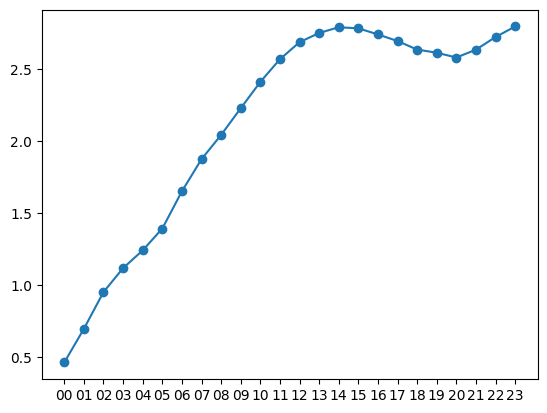

In [44]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

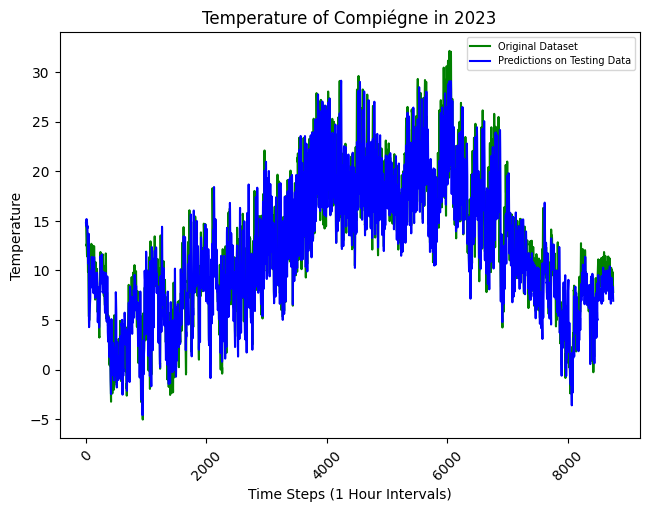

In [45]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing.values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

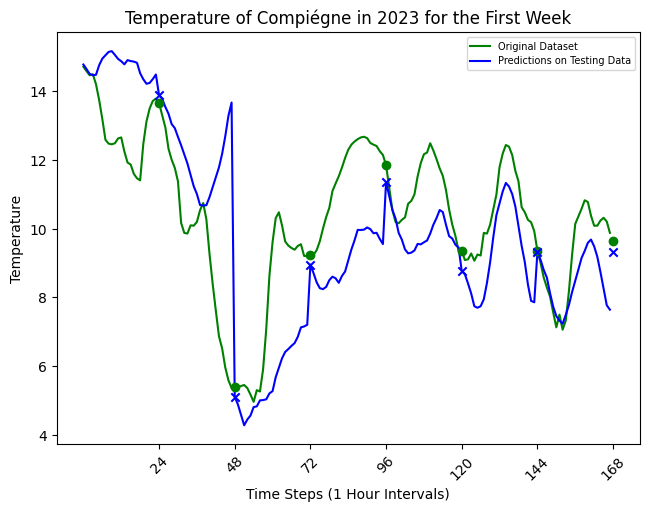

In [46]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing.values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing.values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

# Energy Demand Prediction
A sample dataset was acquired from Keggle to test the LSTM model on energy demand data. The energy demands of years 2015 and 2016 in Spain was taken to predict the energy demands of 2017.

In [29]:
# Reading the datasets and creating the dataframes

dataset = pd.read_csv("energy_dataset.csv", engine='python')
df_energy = pd.DataFrame(dataset)

In [30]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [31]:
df_energy['time'] = df_energy['time'].str.replace('+01:00', '')
df_energy['time'] = df_energy['time'].str.replace('+02:00', '')
df_energy['time'] = df_energy['time'].str.replace(' ', '')
df_energy['time'] = df_energy['time'].str.replace(':', '')
df_energy['time'] = df_energy['time'].str.replace('-', '')

In [32]:
df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y%m%d%H%M%S', infer_datetime_format=True)
df_energy = df_energy.set_index(['time'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\2487084013.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], format='%Y%m%d%H%M%S', infer_datetime_format=True)


In [33]:
print(df_energy.columns)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\1941729268.py:23: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


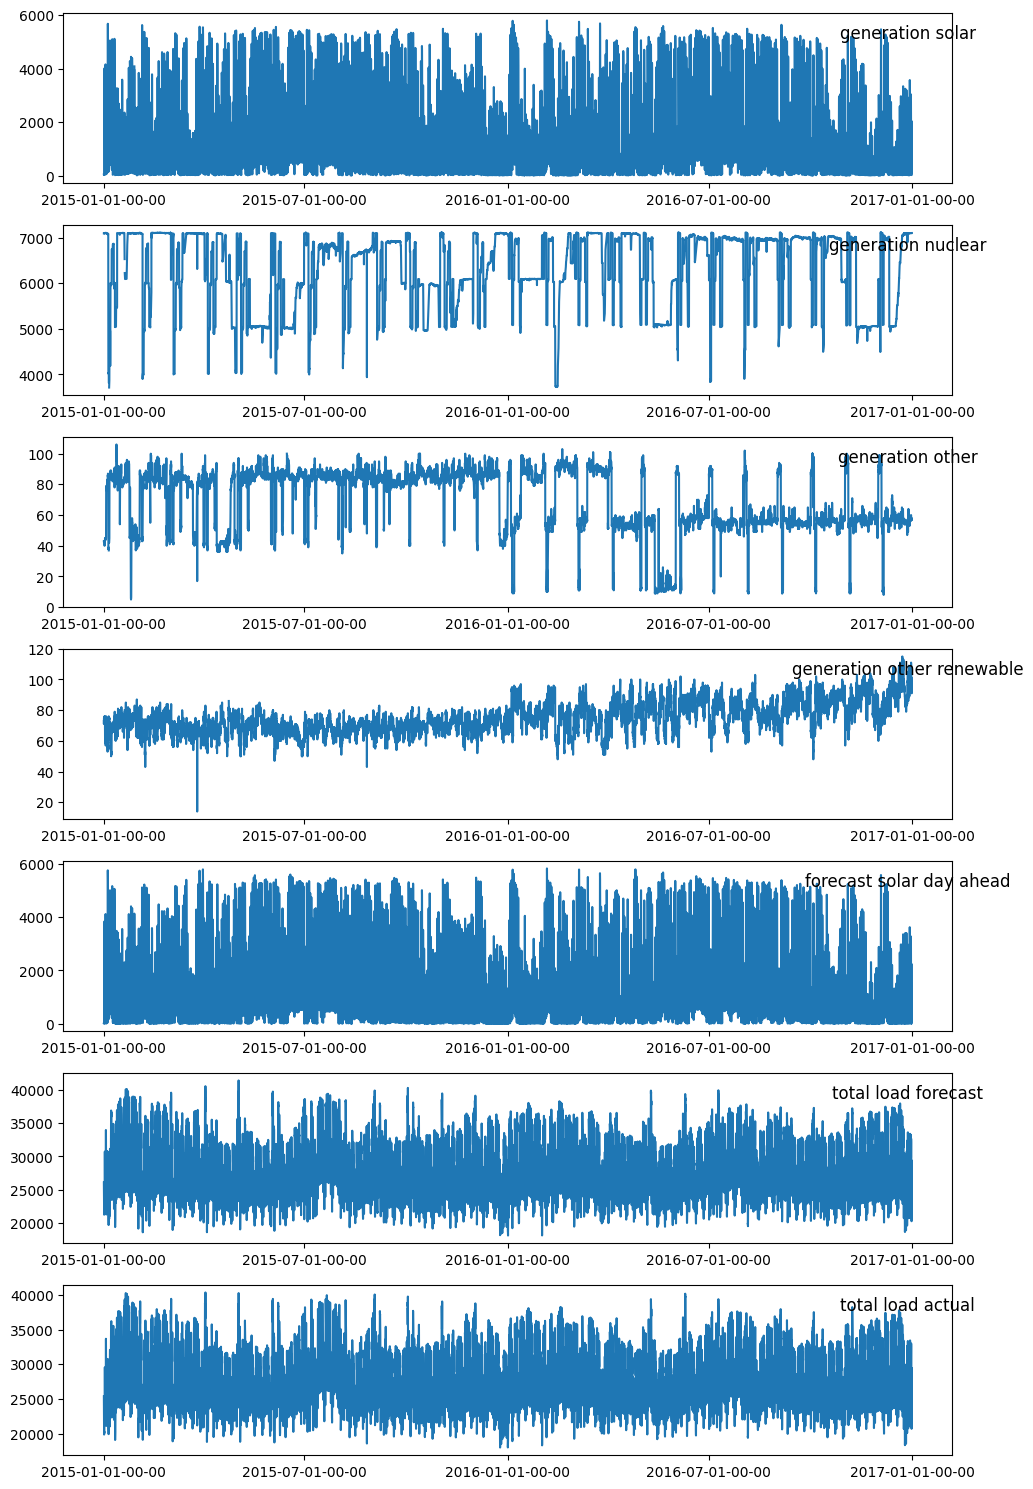

In [34]:
# Creating separate subplots for each series
values = df_energy[0:17532].values
dates = df_energy[0:17532].index  # Get the datetime index

# Specify columns to plot
groups = ['generation solar', 'generation nuclear', 'generation other',
          'generation other renewable', 'forecast solar day ahead', 'total load forecast', 'total load actual',]
i = 1

plt.figure(figsize=(10, 15))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates, values[:, df_energy.columns.get_loc(group)])  # Use datetime index on x-axis
    plt.title(df_energy.columns[df_energy.columns.get_loc(group)], y=0.8, x=0.95)

    # Set major x-axis locator to show only 4 dates
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=5))  # Force 4 labels
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))  # Format as 'YYYY-MM-DD-HH-mm'

    i += 1

plt.tight_layout()
plt.show()

In [35]:
df_2015_2016 = df_energy[0:17544]
df_2017 = df_energy[17544:26304]

df_2015_2016_Solar = df_2015_2016.iloc[:, df_2015_2016.columns.get_loc('generation solar')]

print(df_2015_2016_Solar.head())

df_2017_Solar = df_2017.iloc[:, df_2017.columns.get_loc('generation solar')]

print(df_2017_Solar.head())

time
2015-01-01 00:00:00    49.0
2015-01-01 01:00:00    50.0
2015-01-01 02:00:00    50.0
2015-01-01 03:00:00    50.0
2015-01-01 04:00:00    42.0
Name: generation solar, dtype: float64
time
2017-01-01 00:00:00    30.0
2017-01-01 01:00:00    30.0
2017-01-01 02:00:00    50.0
2017-01-01 03:00:00    87.0
2017-01-01 04:00:00    92.0
Name: generation solar, dtype: float64


In [36]:
# resample data to daily
hourly_groups = df_2015_2016_Solar.resample('H')
hourly_data_training = hourly_groups.sum()

# summarize
print(hourly_data_training.shape)
print(hourly_data_training.head())

# resample data to daily
hourly_groups_testing = df_2017_Solar.resample('H')
hourly_data_testing = hourly_groups_testing.sum()

# summarize
print(hourly_data_testing.shape)
print(hourly_data_testing.head())

(17544,)
time
2015-01-01 00:00:00    49.0
2015-01-01 01:00:00    50.0
2015-01-01 02:00:00    50.0
2015-01-01 03:00:00    50.0
2015-01-01 04:00:00    42.0
Freq: h, Name: generation solar, dtype: float64
(8760,)
time
2017-01-01 00:00:00    30.0
2017-01-01 01:00:00    30.0
2017-01-01 02:00:00    50.0
2017-01-01 03:00:00    87.0
2017-01-01 04:00:00    92.0
Freq: h, Name: generation solar, dtype: float64


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\101138927.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = df_2015_2016_Solar.resample('H')
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\101138927.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups_testing = df_2017_Solar.resample('H')


In [37]:
# save
hourly_data_training.to_csv('Hourly_Solar_Energy_Demand_Training.csv')
hourly_data_testing.to_csv('Hourly_Solar_Energy_Demand_Testing.csv')

In [38]:
# load the new file
dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(731, 24, 1)
0.008459945 0.0051795584
(365, 24, 1)
0.005285412 0.0015856236


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\3748744555.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\3748744555.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])


In [39]:
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

In [41]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 300, 24
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(600, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(250, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [42]:
# load the new file
dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 24
model = build_model(train, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\1215491627.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Solar_Energy_Demand_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\1215491627.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Solar_Energy_Demand_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
d:\Users\ugurhan\Deskt

Epoch 1/300
730/730 - 125s - 171ms/step - loss: 0.0262
Epoch 2/300
730/730 - 115s - 158ms/step - loss: 0.0153
Epoch 3/300
730/730 - 117s - 161ms/step - loss: 0.0138
Epoch 4/300
730/730 - 118s - 161ms/step - loss: 0.0130
Epoch 5/300
730/730 - 117s - 160ms/step - loss: 0.0125
Epoch 6/300
730/730 - 118s - 162ms/step - loss: 0.0123
Epoch 7/300
730/730 - 117s - 161ms/step - loss: 0.0120
Epoch 8/300
730/730 - 117s - 160ms/step - loss: 0.0118
Epoch 9/300
730/730 - 116s - 160ms/step - loss: 0.0116
Epoch 10/300
730/730 - 116s - 159ms/step - loss: 0.0115
Epoch 11/300
730/730 - 116s - 159ms/step - loss: 0.0114
Epoch 12/300
730/730 - 115s - 158ms/step - loss: 0.0112
Epoch 13/300
730/730 - 116s - 159ms/step - loss: 0.0110
Epoch 14/300
730/730 - 115s - 158ms/step - loss: 0.0109
Epoch 15/300
730/730 - 116s - 159ms/step - loss: 0.0107
Epoch 16/300
730/730 - 117s - 160ms/step - loss: 0.0106
Epoch 17/300
730/730 - 116s - 159ms/step - loss: 0.0105
Epoch 18/300
730/730 - 116s - 159ms/step - loss: 0.0103
E

[[[ 63.21857  ]
  [ 86.40091  ]
  [ 58.594086 ]
  ...
  [ 95.38971  ]
  [ 60.94593  ]
  [ 69.55912  ]]

 [[ 38.13705  ]
  [ 10.286328 ]
  [ 40.019566 ]
  ...
  [ 41.44599  ]
  [ 54.903694 ]
  [106.255745 ]]

 [[113.95336  ]
  [ 78.34134  ]
  [ 57.93957  ]
  ...
  [131.99313  ]
  [ 22.440414 ]
  [ 12.025441 ]]

 ...

 [[  2.8881612]
  [ -9.2145   ]
  [-14.152772 ]
  ...
  [ 98.75105  ]
  [ 52.997704 ]
  [116.62259  ]]

 [[ 46.93373  ]
  [ 52.549522 ]
  [ 64.17186  ]
  ...
  [ 91.00556  ]
  [ 47.714394 ]
  [ 97.984764 ]]

 [[ 92.47905  ]
  [ 65.72122  ]
  [ 39.702396 ]
  ...
  [ 54.96535  ]
  [ 37.032913 ]
  [ 63.034355 ]]]
lstm: [852.964] 213.2, 232.3, 224.3, 217.1, 206.6, 189.5, 144.0, 121.5, 326.6, 747.8, 1103.9, 1243.2, 1314.3, 1344.1, 1338.2, 1368.9, 1397.0, 1337.5, 1182.4, 910.2, 568.3, 326.6, 256.4, 243.5


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_11008\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


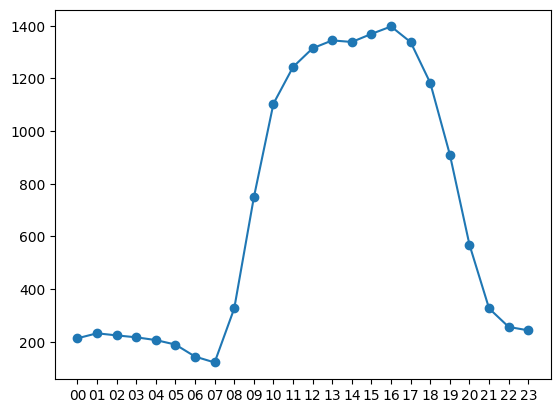

In [44]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

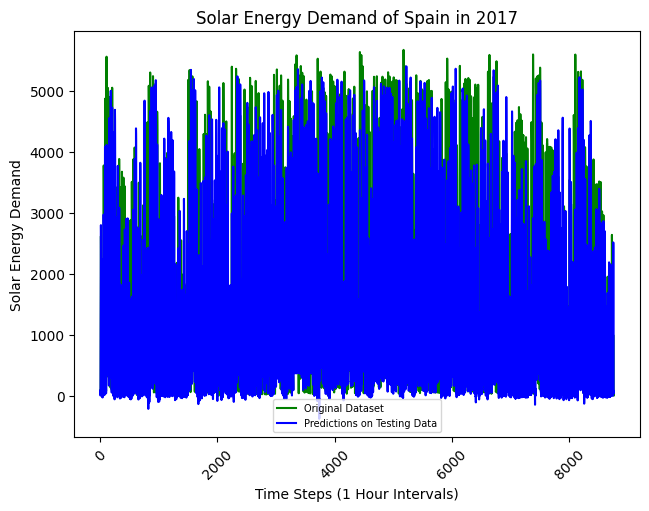

In [45]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing.values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Energy Demand')
plt.title('Solar Energy Demand of Spain in 2017')
plt.show()

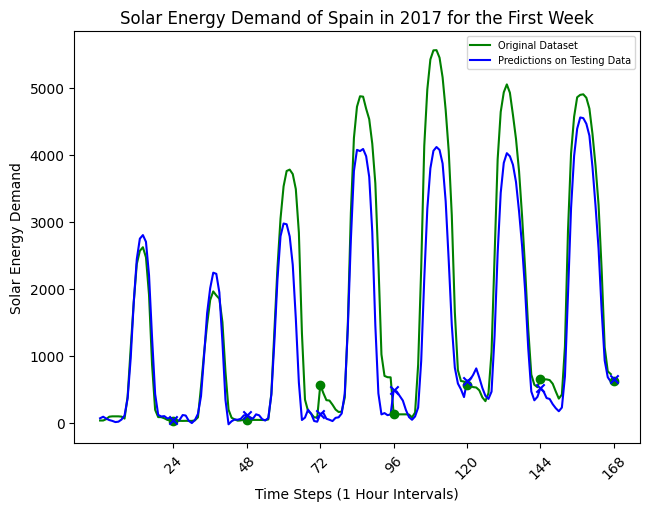

In [46]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing.values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing.values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Solar Energy Demand')
plt.title('Solar Energy Demand of Spain in 2017 for the First Week')
plt.show()

# Encoder-Decoder LSTM Model With Univariate Input
To be able to use this LSTM model with multiple features, an Encoder-Decoder LSTM model is necessary. Before going forward with multivariate input data, it is important to understand the Encoder-Decoder model with the simpler univariate data.

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 150, 72
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(150, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [31]:
# load the new file
dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 24
model = build_model(train, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17864\2783485122.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_Temp_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17864\2783485122.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_Temp_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
d:\Users\ugurhan

Epoch 1/150
365/365 - 61s - 167ms/step - loss: 0.0087
Epoch 2/150
365/365 - 55s - 150ms/step - loss: 0.0061
Epoch 3/150
365/365 - 55s - 150ms/step - loss: 0.0033
Epoch 4/150
365/365 - 55s - 151ms/step - loss: 0.0027
Epoch 5/150
365/365 - 55s - 150ms/step - loss: 0.0026
Epoch 6/150
365/365 - 55s - 150ms/step - loss: 0.0026
Epoch 7/150
365/365 - 54s - 149ms/step - loss: 0.0025
Epoch 8/150
365/365 - 54s - 149ms/step - loss: 0.0025
Epoch 9/150
365/365 - 54s - 148ms/step - loss: 0.0025
Epoch 10/150
365/365 - 54s - 149ms/step - loss: 0.0024
Epoch 11/150
365/365 - 55s - 150ms/step - loss: 0.0024
Epoch 12/150
365/365 - 55s - 149ms/step - loss: 0.0024
Epoch 13/150
365/365 - 55s - 151ms/step - loss: 0.0024
Epoch 14/150
365/365 - 54s - 149ms/step - loss: 0.0024
Epoch 15/150
365/365 - 55s - 150ms/step - loss: 0.0023
Epoch 16/150
365/365 - 54s - 149ms/step - loss: 0.0023
Epoch 17/150
365/365 - 55s - 150ms/step - loss: 0.0023
Epoch 18/150
365/365 - 55s - 150ms/step - loss: 0.0023
Epoch 19/150
365/36

[[[12.960396 ]
  [13.438077 ]
  [13.648842 ]
  ...
  [13.550354 ]
  [13.5038595]
  [13.455048 ]]

 [[13.791711 ]
  [13.766647 ]
  [13.788199 ]
  ...
  [13.431922 ]
  [14.364118 ]
  [15.260699 ]]

 [[ 5.113603 ]
  [ 4.795189 ]
  [ 4.396349 ]
  ...
  [ 7.516789 ]
  [ 7.551208 ]
  [ 7.689551 ]]

 ...

 [[ 8.57394  ]
  [ 8.619281 ]
  [ 8.73299  ]
  ...
  [ 7.7520204]
  [ 7.255066 ]
  [ 6.7366257]]

 [[ 8.306057 ]
  [ 8.235471 ]
  [ 8.216806 ]
  ...
  [ 7.9790864]
  [ 7.8256493]
  [ 7.758845 ]]

 [[ 8.940453 ]
  [ 8.524082 ]
  [ 8.208382 ]
  ...
  [ 4.874989 ]
  [ 4.5360355]
  [ 4.17408  ]]]
lstm: [2.559] 0.5, 0.7, 0.9, 1.2, 1.4, 1.6, 1.8, 2.0, 2.1, 2.3, 2.6, 2.8, 3.0, 3.1, 3.2, 3.3, 3.3, 3.3, 3.2, 3.1, 3.0, 3.0, 3.0, 3.0


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17864\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


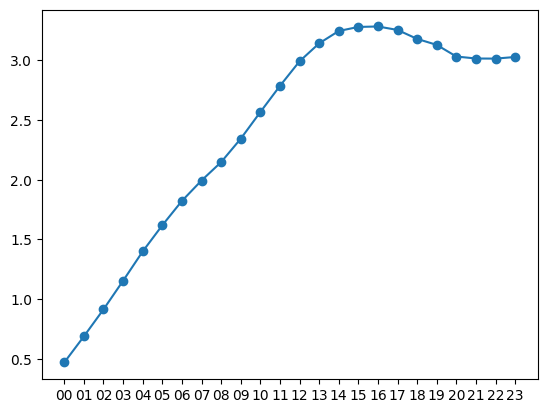

In [34]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

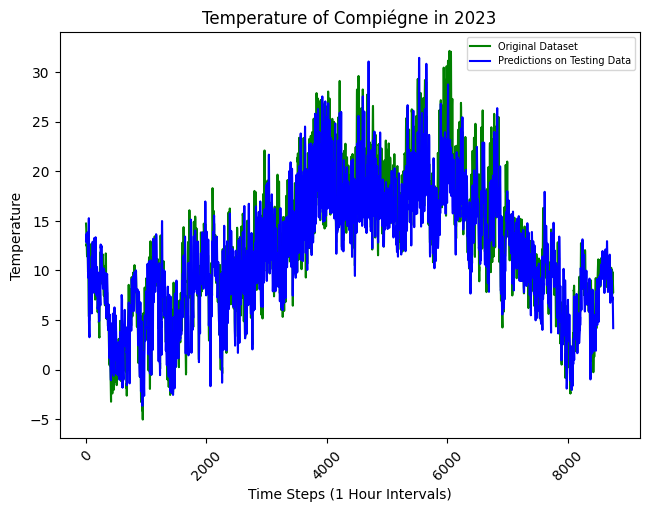

In [35]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing.values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

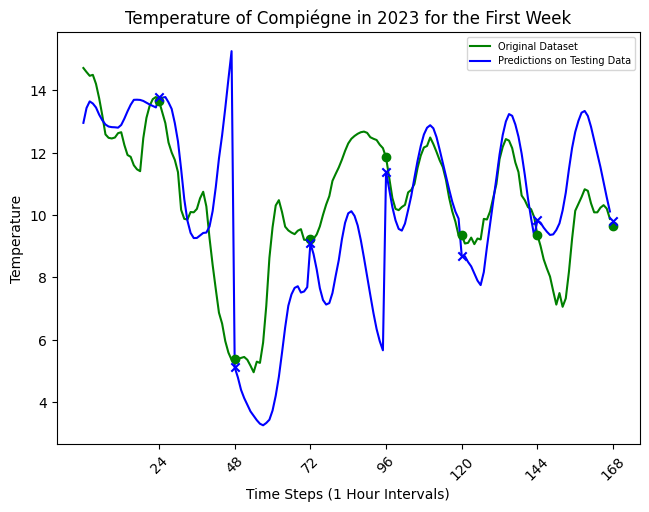

In [36]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing.values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing.values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()

# Encoder-Decoder LSTM Model With Multivariate Input

In [50]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 1]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [51]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [30]:
# Drop the 'Int' and 'P' columns

df_2021_2022_dropped = df_2021_2022_copy.drop(['Int'], axis=1)
df_2021_2022_dropped = df_2021_2022_dropped.drop(['P'], axis=1)
df_2021_2022_dropped = df_2021_2022_dropped.drop(['WS10m'], axis=1)
df_2021_2022_dropped = df_2021_2022_dropped.drop(['G(i)'], axis=1)

print(df_2021_2022_dropped.head())

df_2023_dropped = df_2023_copy.drop(['Int'], axis=1)
df_2023_dropped = df_2023_dropped.drop(['P'], axis=1)
df_2023_dropped = df_2023_dropped.drop(['WS10m'], axis=1)
df_2023_dropped = df_2023_dropped.drop(['G(i)'], axis=1)

print(df_2023_dropped.head())

                     H_sun   T2m
time                            
2021-01-01 00:10:00    0.0 -0.21
2021-01-01 01:10:00    0.0 -0.44
2021-01-01 02:10:00    0.0 -0.48
2021-01-01 03:10:00    0.0 -0.47
2021-01-01 04:10:00    0.0 -0.50
                     H_sun    T2m
time                             
2023-01-01 00:10:00    0.0  14.72
2023-01-01 01:10:00    0.0  14.59
2023-01-01 02:10:00    0.0  14.47
2023-01-01 03:10:00    0.0  14.50
2023-01-01 04:10:00    0.0  14.21


In [31]:
# resample data to daily
hourly_groups = df_2021_2022_dropped.resample('H')
hourly_data_training = hourly_groups.sum()

# summarize
print(hourly_data_training.shape)
print(hourly_data_training.head())

# resample data to daily
hourly_groups_testing = df_2023_dropped.resample('H')
hourly_data_testing = hourly_groups_testing.sum()

# summarize
print(hourly_data_testing.shape)
print(hourly_data_testing.head())

(17520, 2)
                     H_sun   T2m
time                            
2021-01-01 00:00:00    0.0 -0.21
2021-01-01 01:00:00    0.0 -0.44
2021-01-01 02:00:00    0.0 -0.48
2021-01-01 03:00:00    0.0 -0.47
2021-01-01 04:00:00    0.0 -0.50
(8760, 2)
                     H_sun    T2m
time                             
2023-01-01 00:00:00    0.0  14.72
2023-01-01 01:00:00    0.0  14.59
2023-01-01 02:00:00    0.0  14.47
2023-01-01 03:00:00    0.0  14.50
2023-01-01 04:00:00    0.0  14.21


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\3726549048.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = df_2021_2022_dropped.resample('H')
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\3726549048.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups_testing = df_2023_dropped.resample('H')


In [32]:
# save
hourly_data_training.to_csv('Hourly_System_Power_Data_Training.csv')
hourly_data_testing.to_csv('Hourly_System_Power_Data_Testing.csv')

In [46]:
def reframe_datasets(training, testing):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/24))
	test = array(np.split(testing, len(testing)/24))

	return train, test

In [54]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)

	# define parameters
	verbose, epochs, batch_size = 2, 150, 72
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(150, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [55]:
# load the new file
dataset_training = pd.read_csv('Hourly_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
dataset_testing = pd.read_csv('Hourly_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

# Preparing dataset for LSTM training

df_lstm_training = dataset_training.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = dataset_testing.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

train, test = reframe_datasets(df_lstm_training, df_lstm_testing)

# Build a model
n_input = 24
model = build_model(train, n_input)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\3285196152.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_training = pd.read_csv('Hourly_System_Power_Data_Training.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\3285196152.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_testing = pd.read_csv('Hourly_System_Power_Data_Testing.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])
d:\Users\ugurhan\Desktop\LST

Epoch 1/150
243/243 - 53s - 218ms/step - loss: 0.0106
Epoch 2/150
243/243 - 46s - 191ms/step - loss: 0.0032
Epoch 3/150
243/243 - 47s - 193ms/step - loss: 0.0026
Epoch 4/150
243/243 - 47s - 194ms/step - loss: 0.0024
Epoch 5/150
243/243 - 48s - 196ms/step - loss: 0.0024
Epoch 6/150
243/243 - 47s - 195ms/step - loss: 0.0023
Epoch 7/150
243/243 - 48s - 197ms/step - loss: 0.0023
Epoch 8/150
243/243 - 48s - 196ms/step - loss: 0.0022
Epoch 9/150
243/243 - 44s - 180ms/step - loss: 0.0022
Epoch 10/150
243/243 - 44s - 181ms/step - loss: 0.0022
Epoch 11/150
243/243 - 42s - 172ms/step - loss: 0.0022
Epoch 12/150
243/243 - 47s - 195ms/step - loss: 0.0022
Epoch 13/150
243/243 - 47s - 195ms/step - loss: 0.0022
Epoch 14/150
243/243 - 47s - 195ms/step - loss: 0.0021
Epoch 15/150
243/243 - 48s - 197ms/step - loss: 0.0021
Epoch 16/150
243/243 - 48s - 196ms/step - loss: 0.0021
Epoch 17/150
243/243 - 45s - 185ms/step - loss: 0.0021
Epoch 18/150
243/243 - 46s - 191ms/step - loss: 0.0020
Epoch 19/150
243/24

In [63]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler):

	# history is a list of daily data
	history = [x for x in train]

	# walk-forward validation over each day
	predictions = list()

	for i in range(len(test)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history.append(test[i, :])

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	target_scaler.min_ = scaler.min_[1].reshape(1,)
	target_scaler.scale_ = scaler.scale_[1].reshape(1,)
	target_scaler.data_min_ = scaler.data_min_[1].reshape(1,)
	target_scaler.data_max_ = scaler.data_max_[1].reshape(1,)
	target_scaler.data_range_ = scaler.data_range_[1].reshape(1,)

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	print(np.shape(predictions))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)		
	
	score, scores = evaluate_forecasts(test[:, :, 1], predictions)
	return predictions, score, scores

(365, 24, 1)
[[[12.134564 ]
  [11.922239 ]
  [11.575404 ]
  ...
  [11.555483 ]
  [11.359958 ]
  [11.278928 ]]

 [[13.422411 ]
  [13.335877 ]
  [13.242651 ]
  ...
  [13.25866  ]
  [13.230318 ]
  [13.257533 ]]

 [[ 4.8007665]
  [ 4.3948493]
  [ 4.19863  ]
  ...
  [ 7.3572383]
  [ 7.2591844]
  [ 7.22441  ]]

 ...

 [[ 8.280277 ]
  [ 8.405366 ]
  [ 8.339393 ]
  ...
  [ 8.00131  ]
  [ 7.7952237]
  [ 7.6452007]]

 [[ 8.328663 ]
  [ 8.586351 ]
  [ 8.626446 ]
  ...
  [ 7.7860184]
  [ 7.598573 ]
  [ 7.49566  ]]

 [[ 8.710252 ]
  [ 8.759327 ]
  [ 8.610401 ]
  ...
  [ 6.5675373]
  [ 6.3487673]
  [ 5.937534 ]]]
lstm: [2.450] 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.6, 1.8, 2.0, 2.3, 2.5, 2.7, 2.8, 3.0, 3.0, 3.1, 3.1, 3.1, 3.0, 3.0, 3.0, 3.0, 3.1, 3.1


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_7248\529680068.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%s: [%.3f] %s' % (name, score, s_scores))


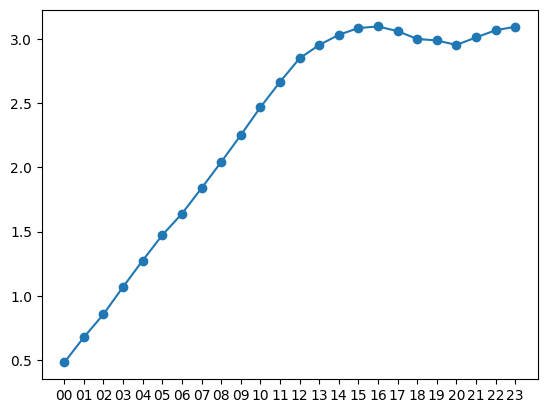

In [64]:
# Evaluate model and get scores
predictions, score, scores = evaluate_model(model, train, test, n_input, scaler)

print(predictions)

# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
         '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hours, scores, marker='o', label='lstm')
plt.show()

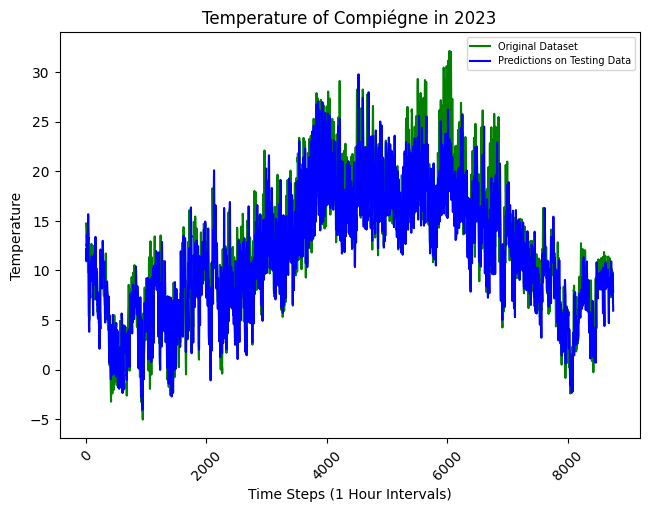

In [65]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(dataset_testing['T2m'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023')
plt.show()

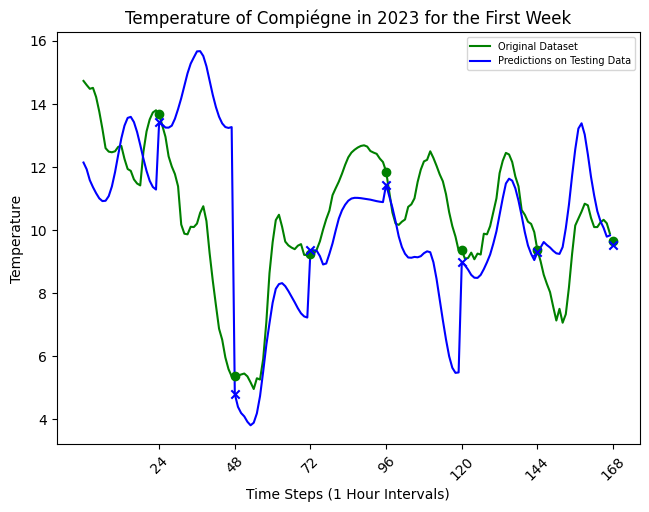

In [66]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(dataset_testing['T2m'].values[:168], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:168], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144, 168]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = dataset_testing['T2m'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (1 Hour Intervals)')
plt.ylabel('Temperature')
plt.title('Temperature of Compiégne in 2023 for the First Week')
plt.show()